# Project 1 - Getting Started

### Notebook Setup

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

In [2]:
# Settings required in new code block due to an error in latest Jupyter version
sns.set()
matplotlib.rcParams["figure.dpi"] = 300
sns.set(font_scale=1.25, rc={"figure.figsize": (20, 10)})
sns.set_style("ticks")  # ticks
sns.set_palette("colorblind")

### Load data using Pandas

In [14]:
data_salaries = pd.read_csv("./data/Salaries.csv")
data_people = pd.read_csv("./data/People.csv")
data_teams = pd.read_csv("./data/Teams.csv")
data_batting = pd.read_csv("./data/Batting.csv")

### Aggregate salary per year

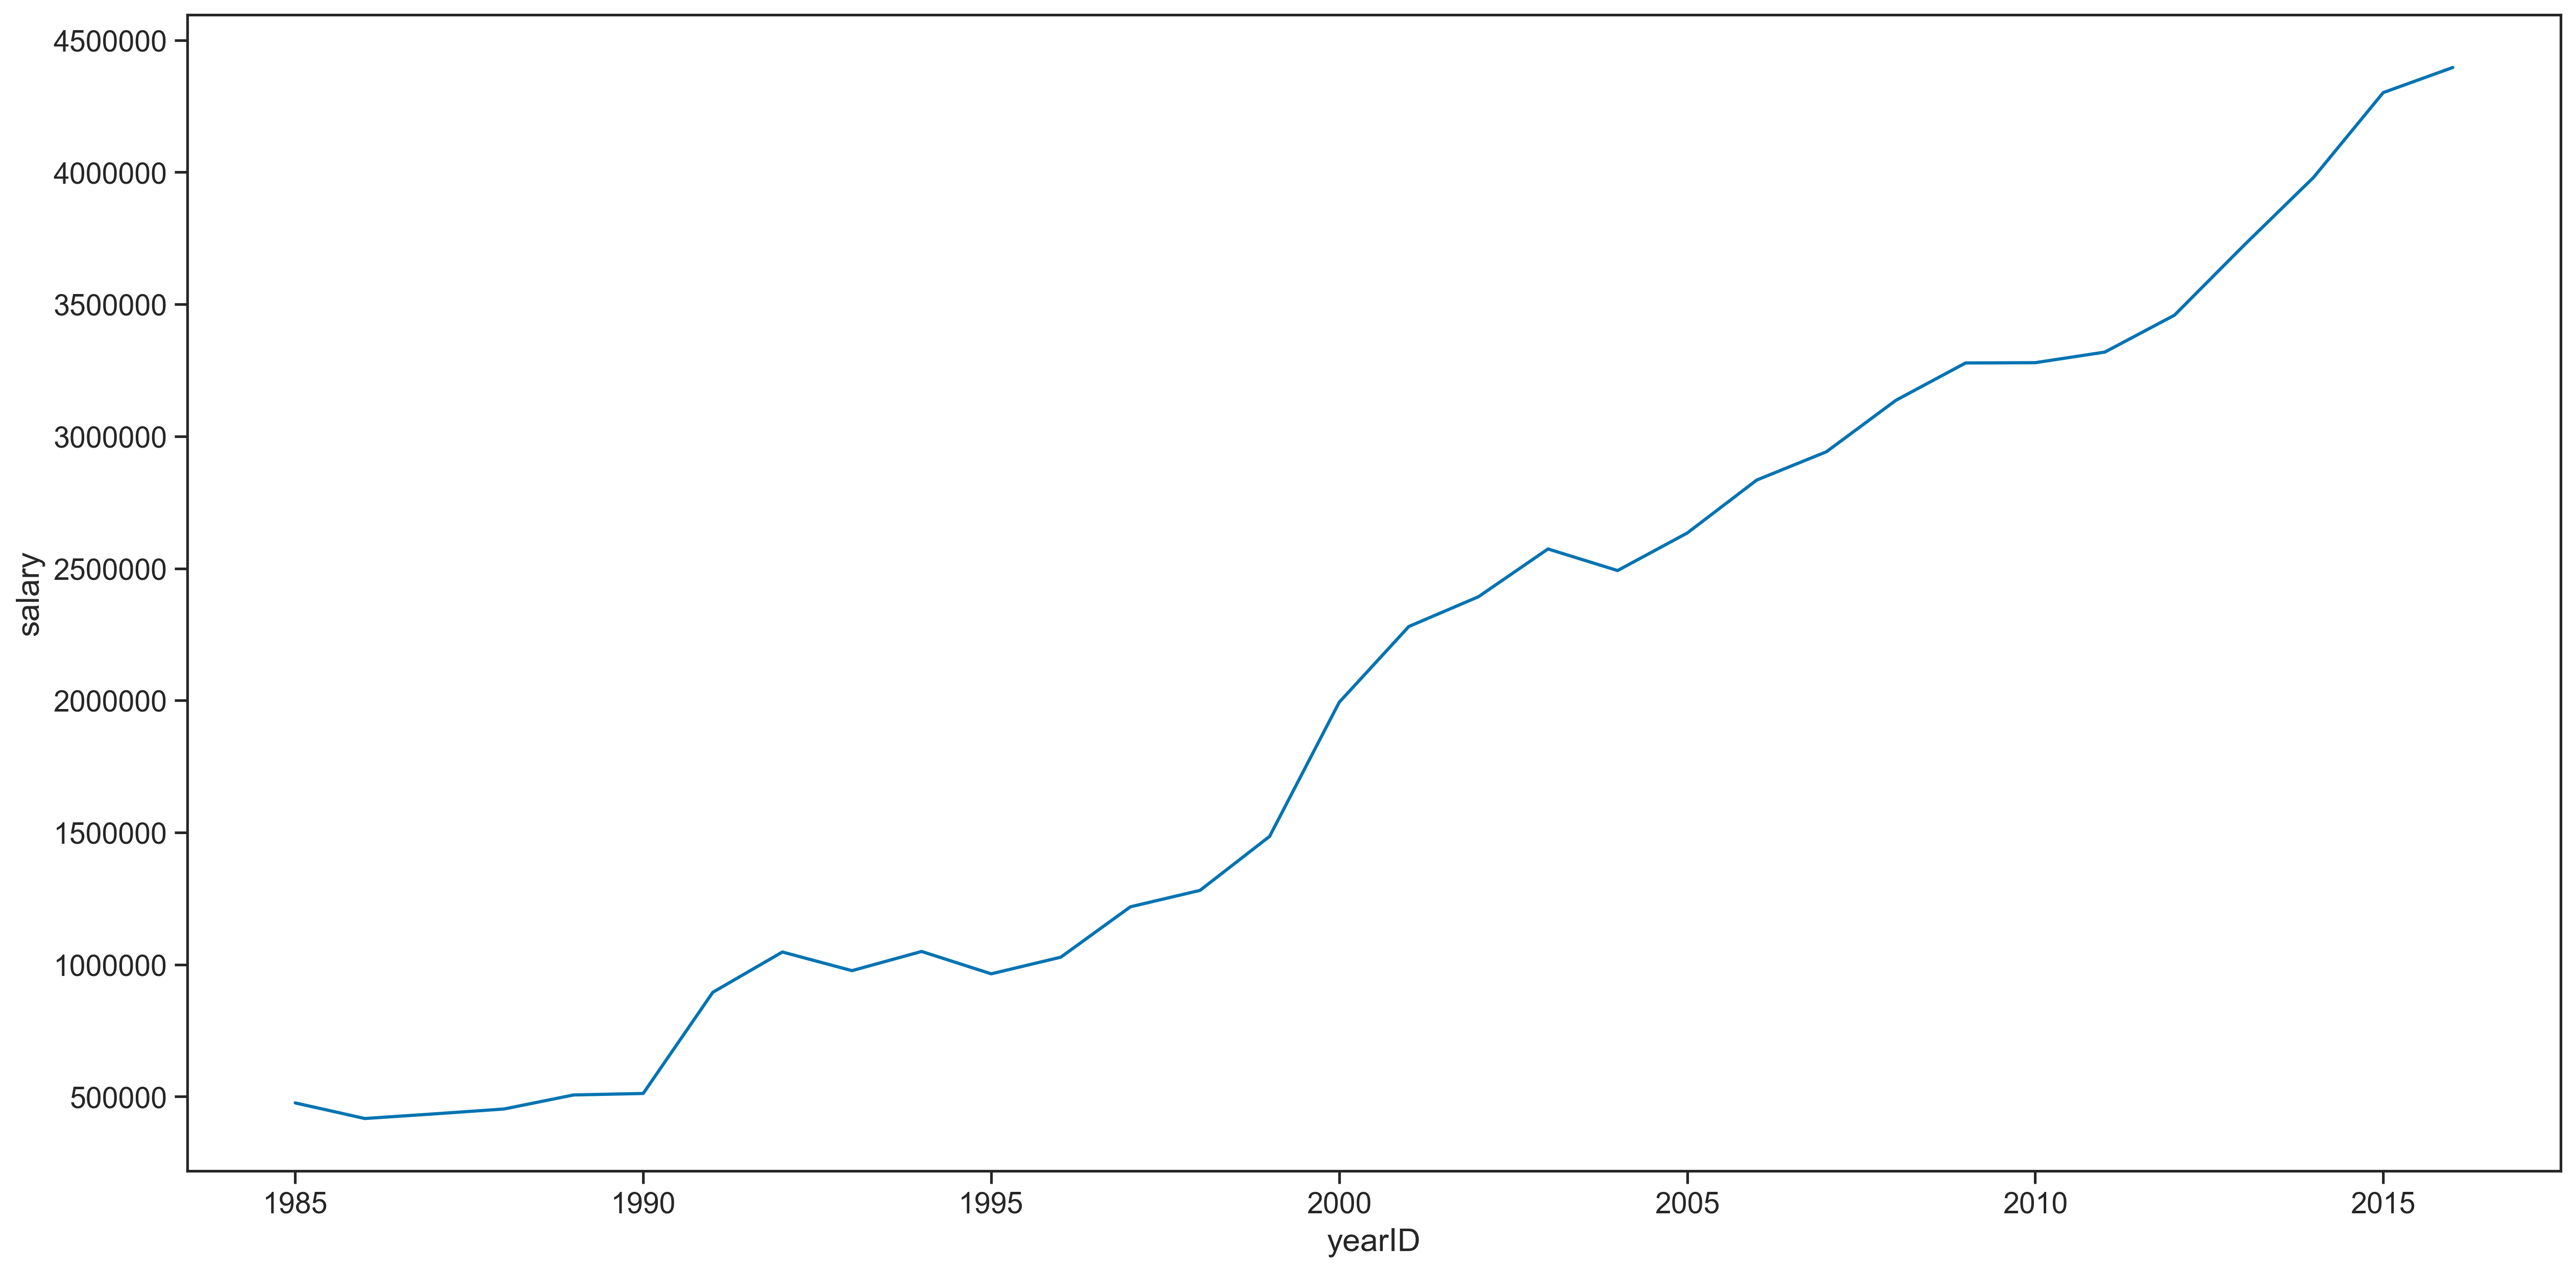

In [13]:
data_salary_ag = data_salaries.groupby(['yearID'], as_index=False).mean()
sns.lineplot(x='yearID', y='salary', data=data_salary_ag)

### Salary vs Batting Average, HomeRuns, AtBats

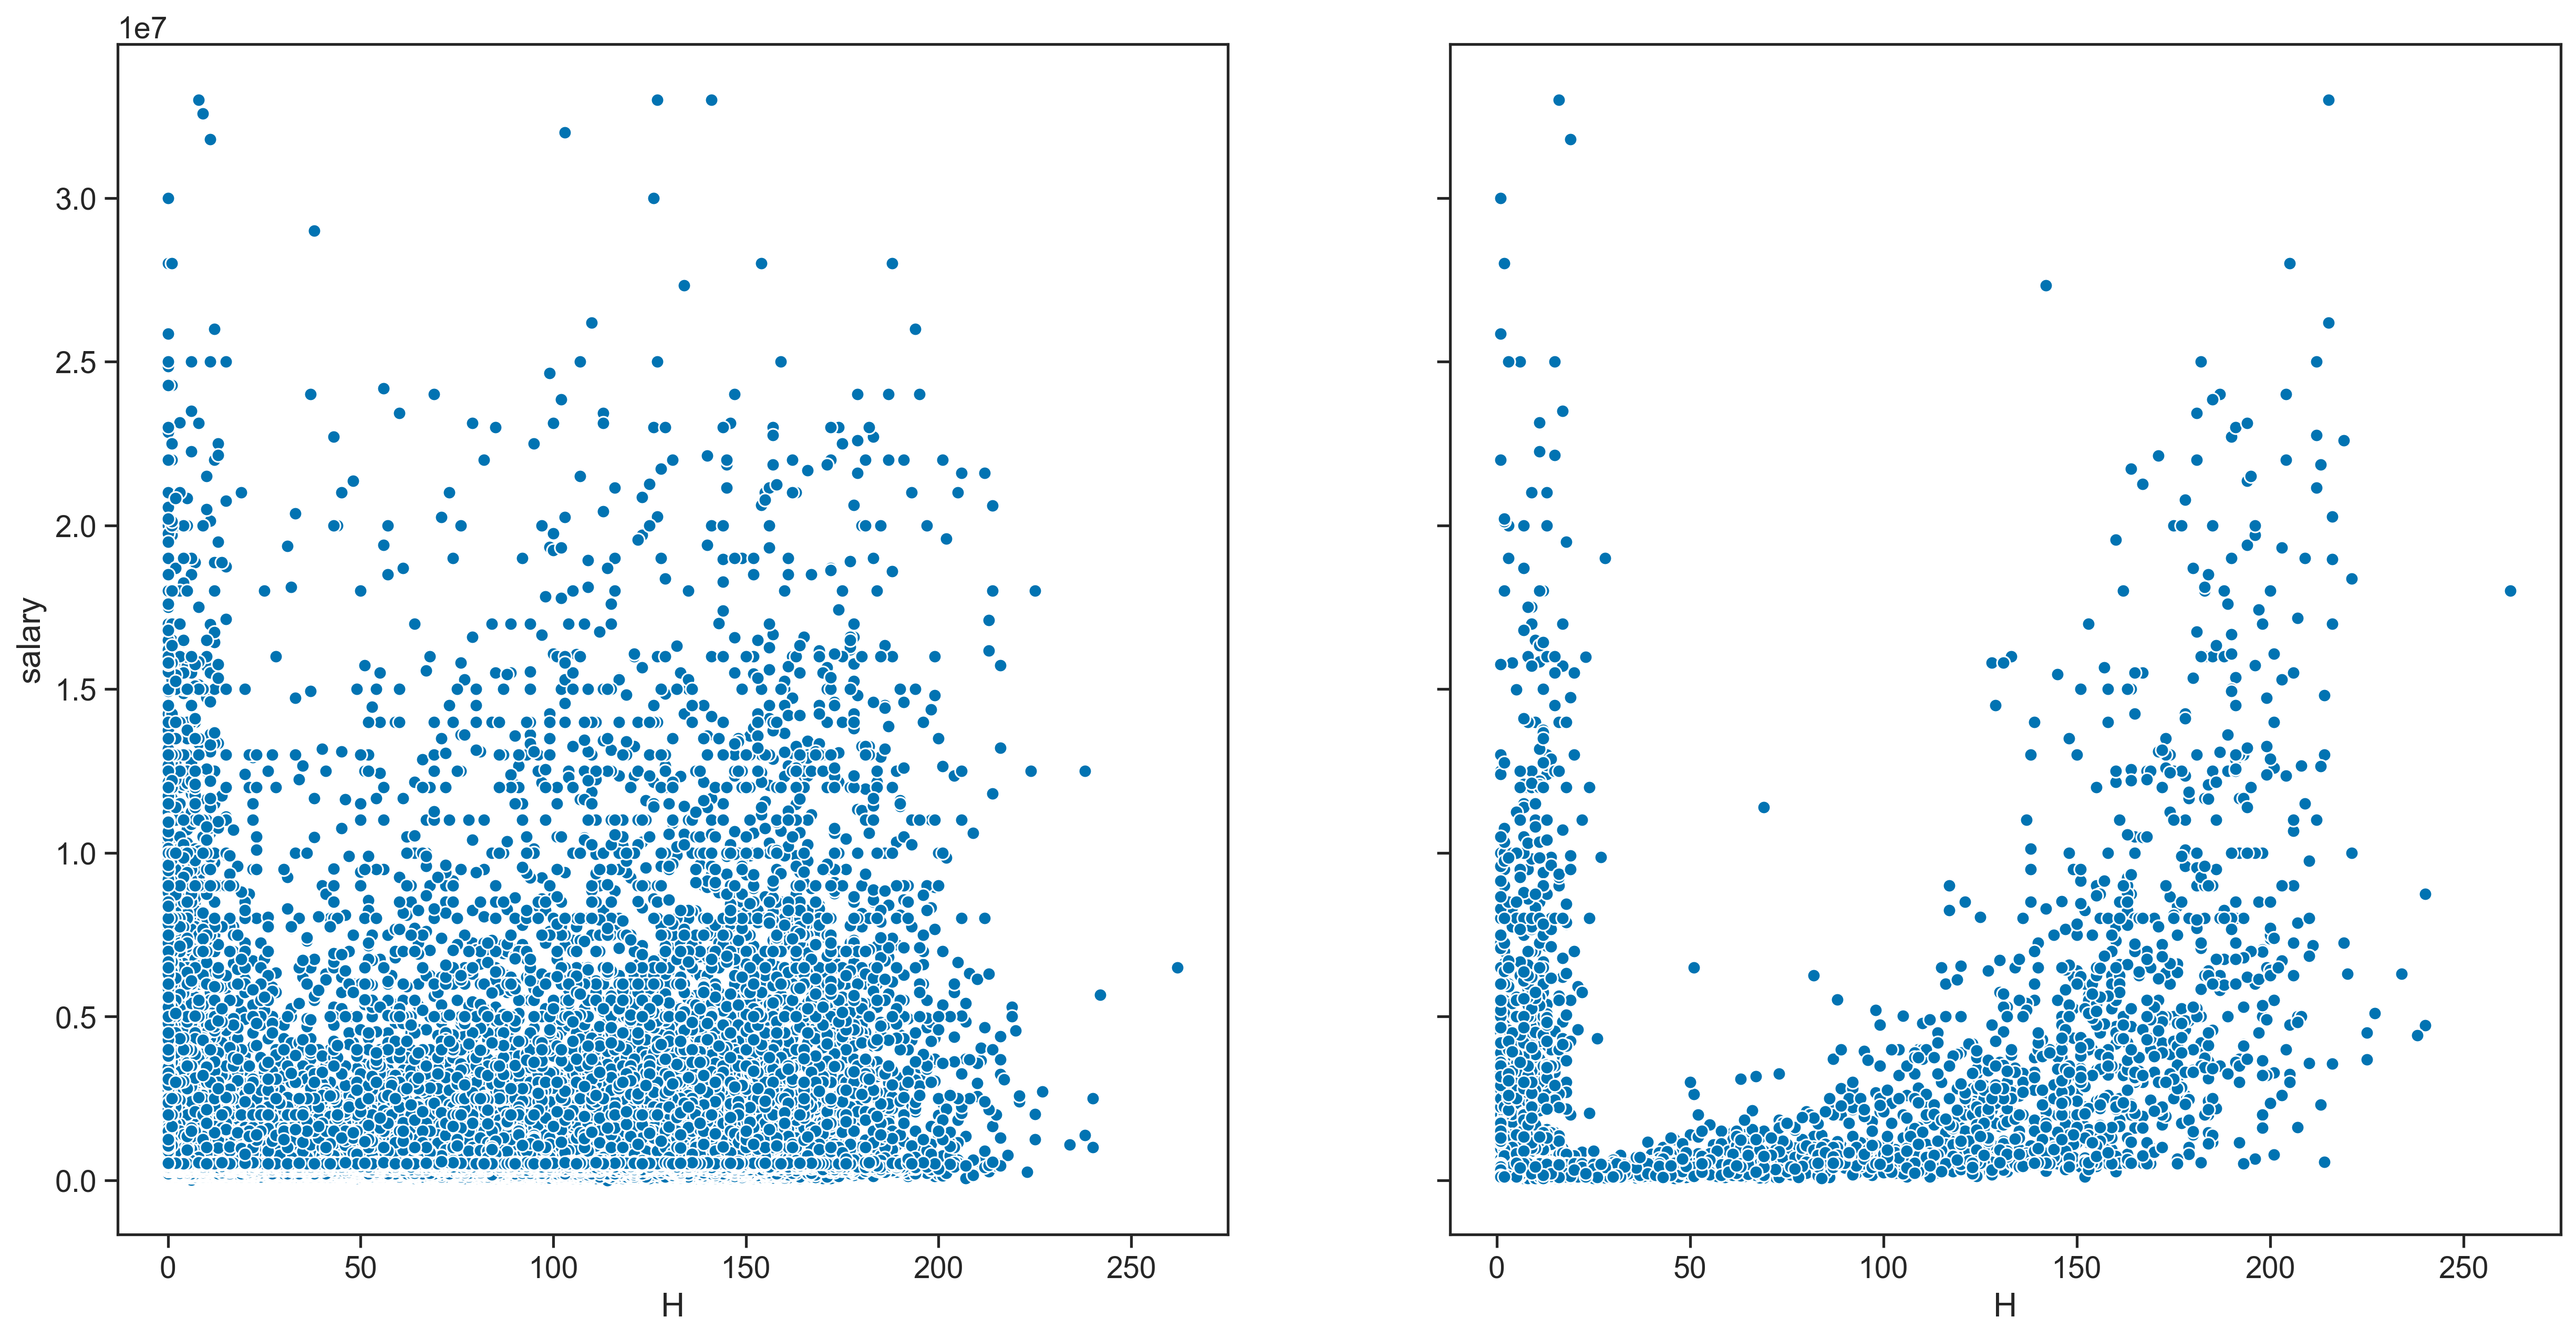

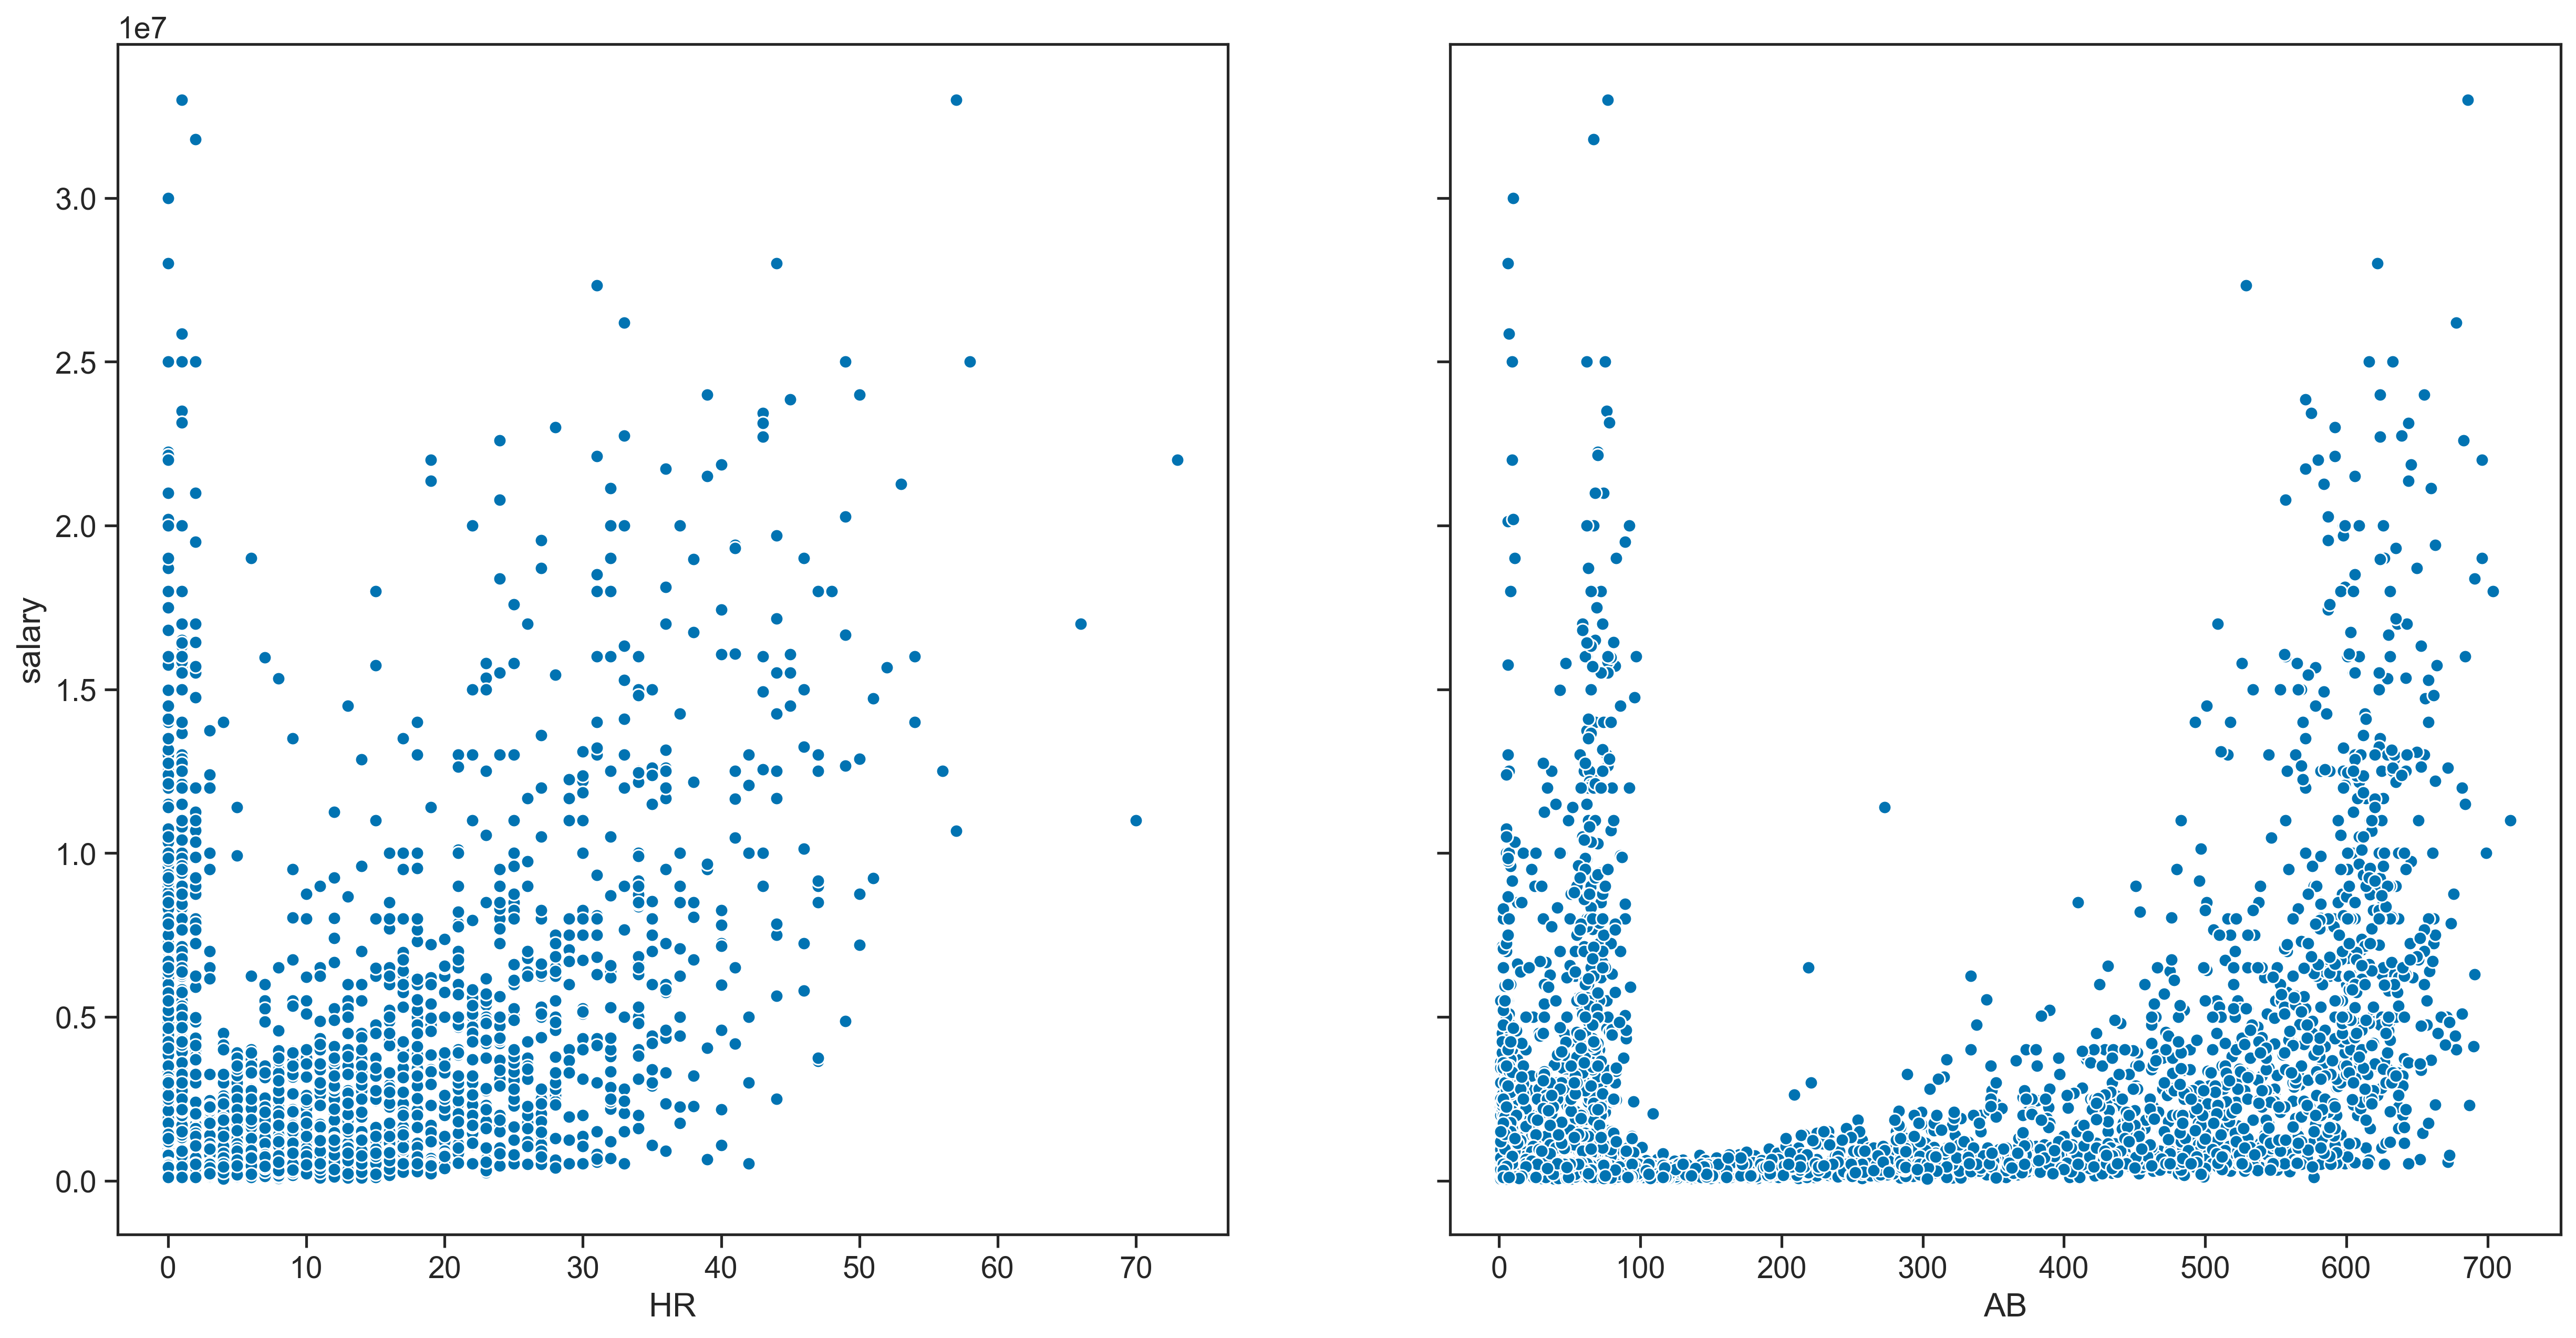

In [24]:
playerSalBat = pd.merge(data_salaries, data_batting, on=['playerID', 'yearID', 'teamID','lgID'] )
playerSalBat = playerSalBat[['yearID', 'teamID', 'lgID', 'playerID', 'salary','AB', 'H', 'HR']].dropna()
playerSalBat_ag = playerSalBat.groupby('playerID').agg({'H':'max', 'salary':'max', 'HR':'max', 'AB':'max'}).reset_index()

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.scatterplot('H', 'salary', data=playerSalBat, ax=ax1)
sns.scatterplot('H', 'salary', data=playerSalBat_ag[playerSalBat_ag.H > 0], ax=ax2)

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.scatterplot('HR', 'salary', data=playerSalBat_ag[playerSalBat_ag.H > 0], ax=ax1)
sns.scatterplot('AB', 'salary', data=playerSalBat_ag[playerSalBat_ag.H > 0], ax=ax2)

### Transforming the scatterplots to lineplots

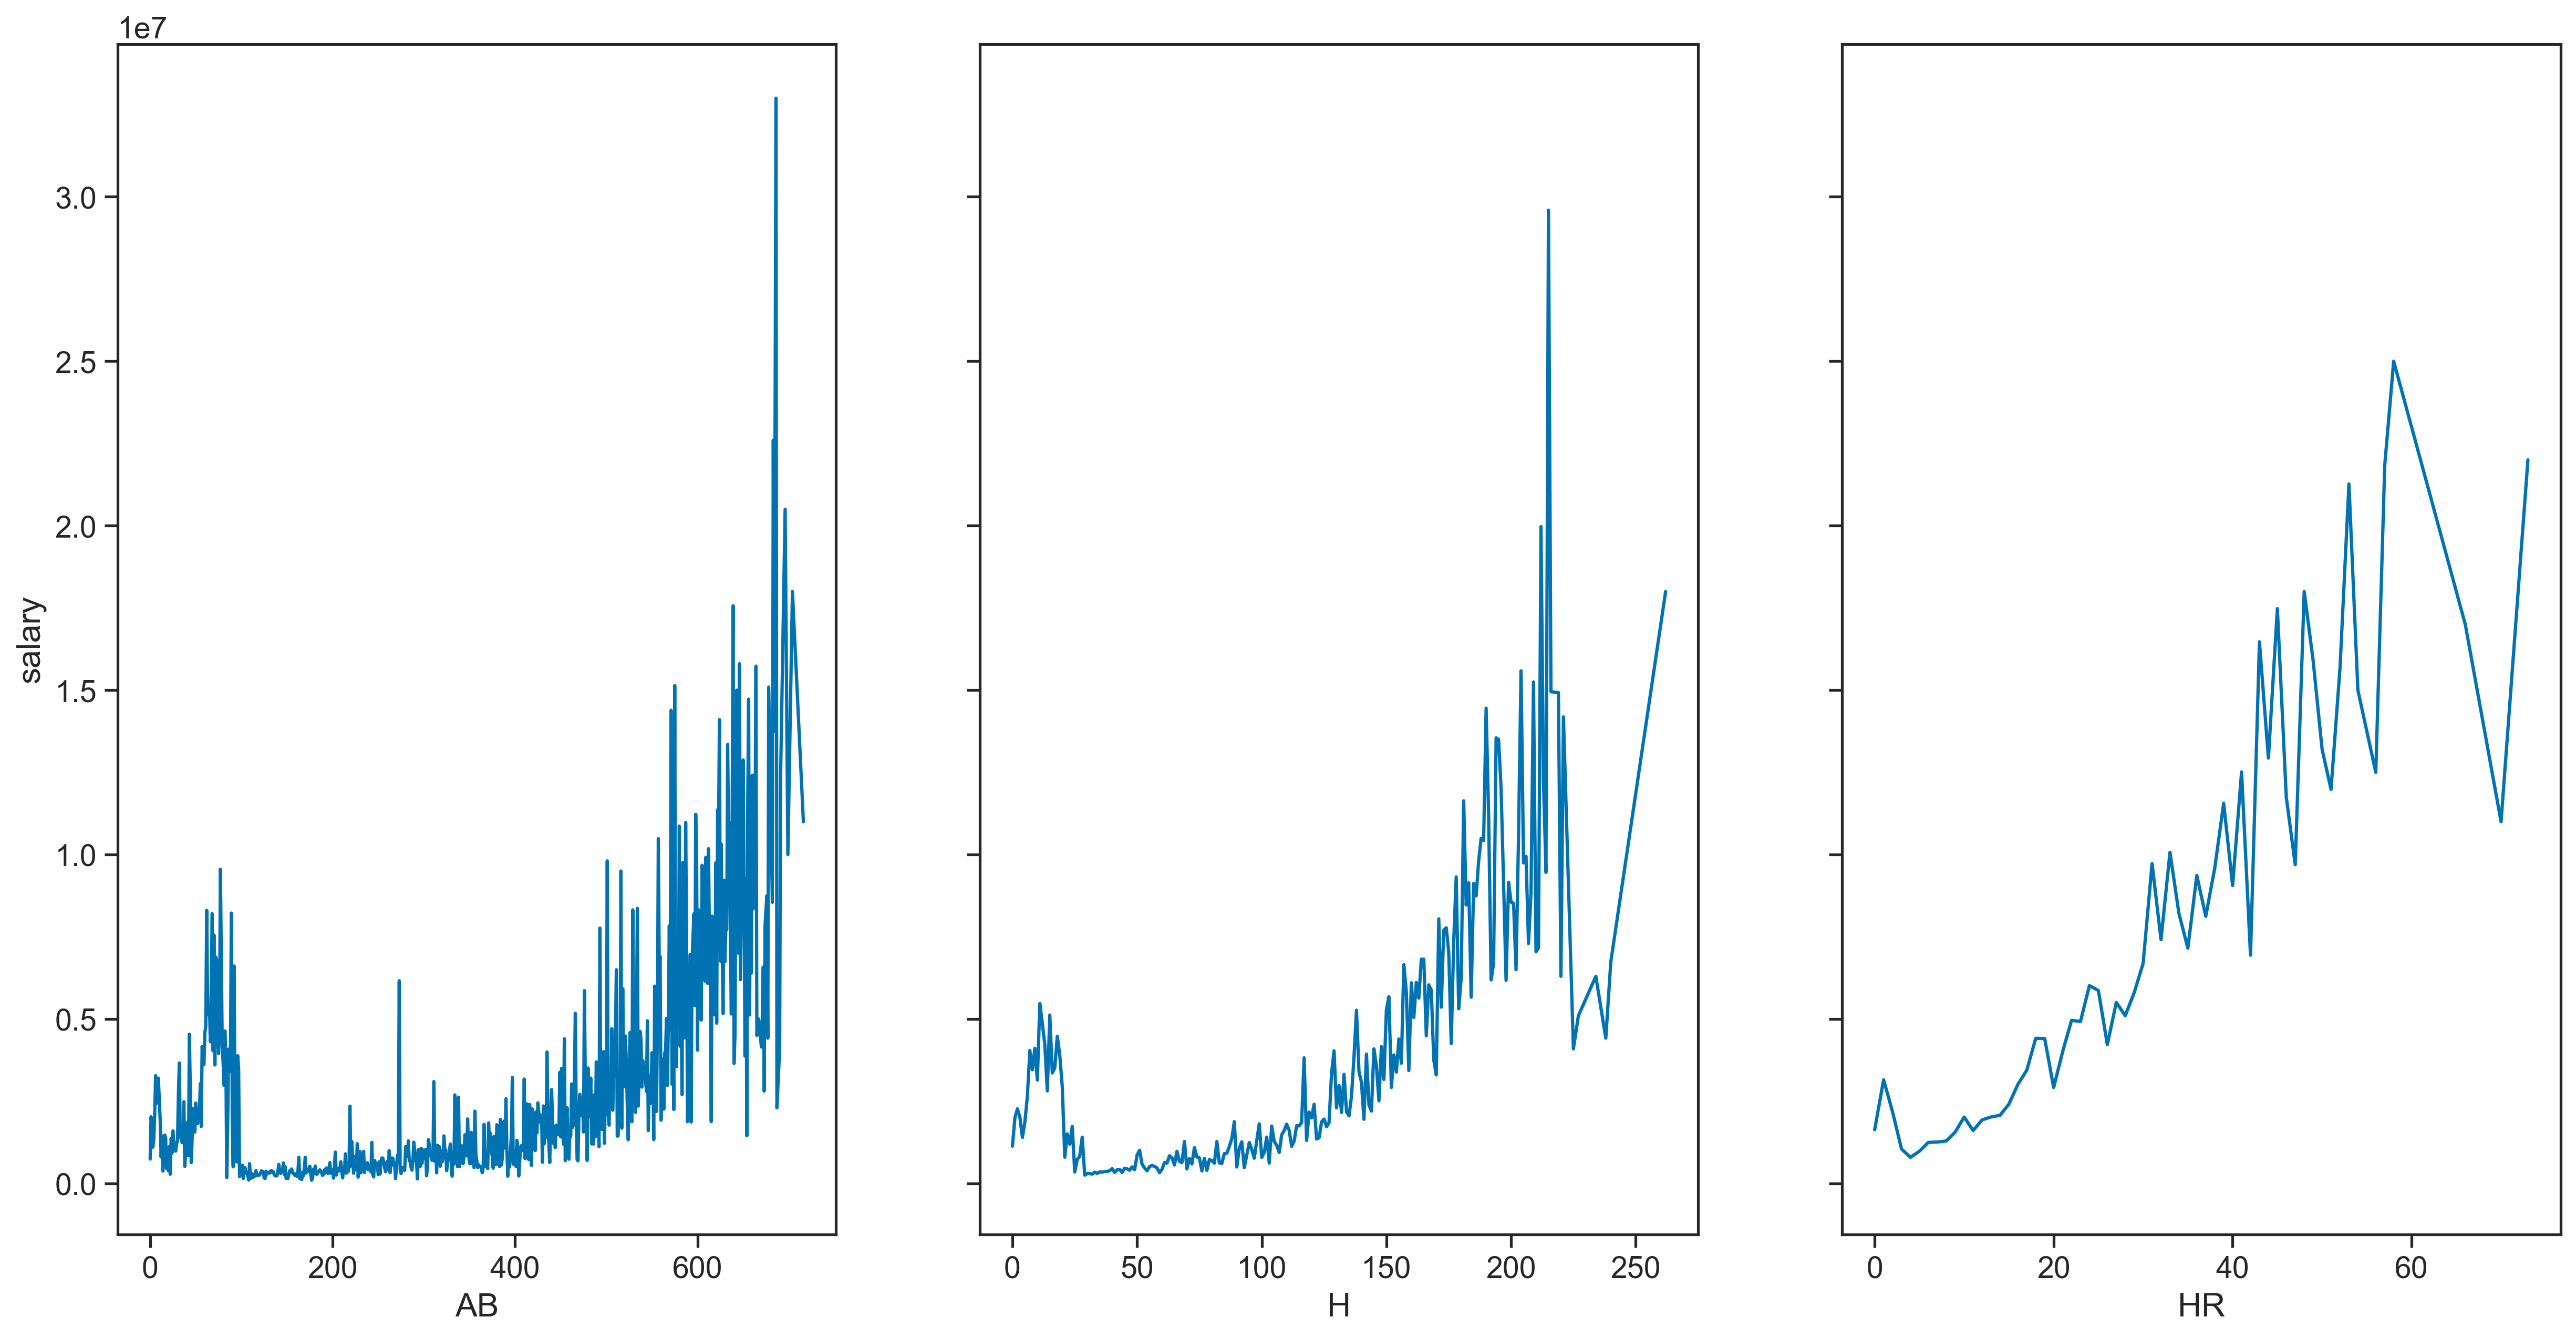

In [23]:
data_ab = playerSalBat_ag.groupby('AB').agg({'salary':'mean'}).reset_index()
data_h = playerSalBat_ag.groupby('H').agg({'salary':'mean'}).reset_index()
data_hr = playerSalBat_ag.groupby('HR').agg({'salary':'mean'}).reset_index()


fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True)
sns.lineplot('AB', 'salary', data=data_ab, ax=ax1)
sns.lineplot('H', 'salary', data=data_h, ax=ax2)
sns.lineplot('HR', 'salary', data=data_hr, ax=ax3)

### Join the pl

In [4]:
data = data_salaries.merge(data_teams, left_on=["yearID", "teamID", "lgID"], right_on=["yearID", "teamID", "lgID"])
data = data.merge(data_people, left_on=["playerID"], right_on=["playerID"])
data = data[["yearID", "teamID", "lgID", "playerID", "salary", "Rank", "nameFirst", "nameLast", "name", "attendance", "W", "L"]]
data = data[data["salary"] != 0]

### Combine player salaries on each team

In [5]:
team_salaries = {}
for index, row in data.iterrows():
    team_salaries[(row["yearID"], row["teamID"], row["lgID"])] = []
for index, row in data.iterrows():
    team_salaries[(row["yearID"], row["teamID"], row["lgID"])].append(row["salary"])

### Find the mean, min, max, and std for each team

In [6]:
data_analysis = pd.DataFrame(columns=["yearID", "teamID", "lgID", "mean", "min", "max", "std"])

for key in team_salaries:
    team_salaries[key] = np.array(sorted(team_salaries[key]))
    
    yearID = key[0]
    teamID = key[1]
    lgID = key[2]
    
    team_name = data[(data["yearID"] == yearID) & (data["teamID"] == teamID) & (data["lgID"] == lgID)]["name"].iloc[0]
    W = data[(data["yearID"] == yearID) & (data["teamID"] == teamID) & (data["lgID"] == lgID)]["W"].iloc[0],
    L = data[(data["yearID"] == yearID) & (data["teamID"] == teamID) & (data["lgID"] == lgID)]["L"].iloc[0],
    
    data_analysis = data_analysis.append({
        "yearID":yearID,
        "teamID":teamID,
        "lgID":lgID,
        "team_name":team_name,
        "mean":round(team_salaries[key].mean(), 2),
        "min":team_salaries[key].min(),
        "max":team_salaries[key].max(),
        "std":team_salaries[key].std(),
        "top_difference":team_salaries[key][-1] - team_salaries[key][-2],
        "win_percentage":100 * (W[0] / (W[0] + L[0])),
        }, ignore_index=True)

In [7]:
largest_variance = data_analysis.iloc[data_analysis["top_difference"].idxmax()]
smallest_variance = data_analysis.iloc[data_analysis["std"].idxmin()]

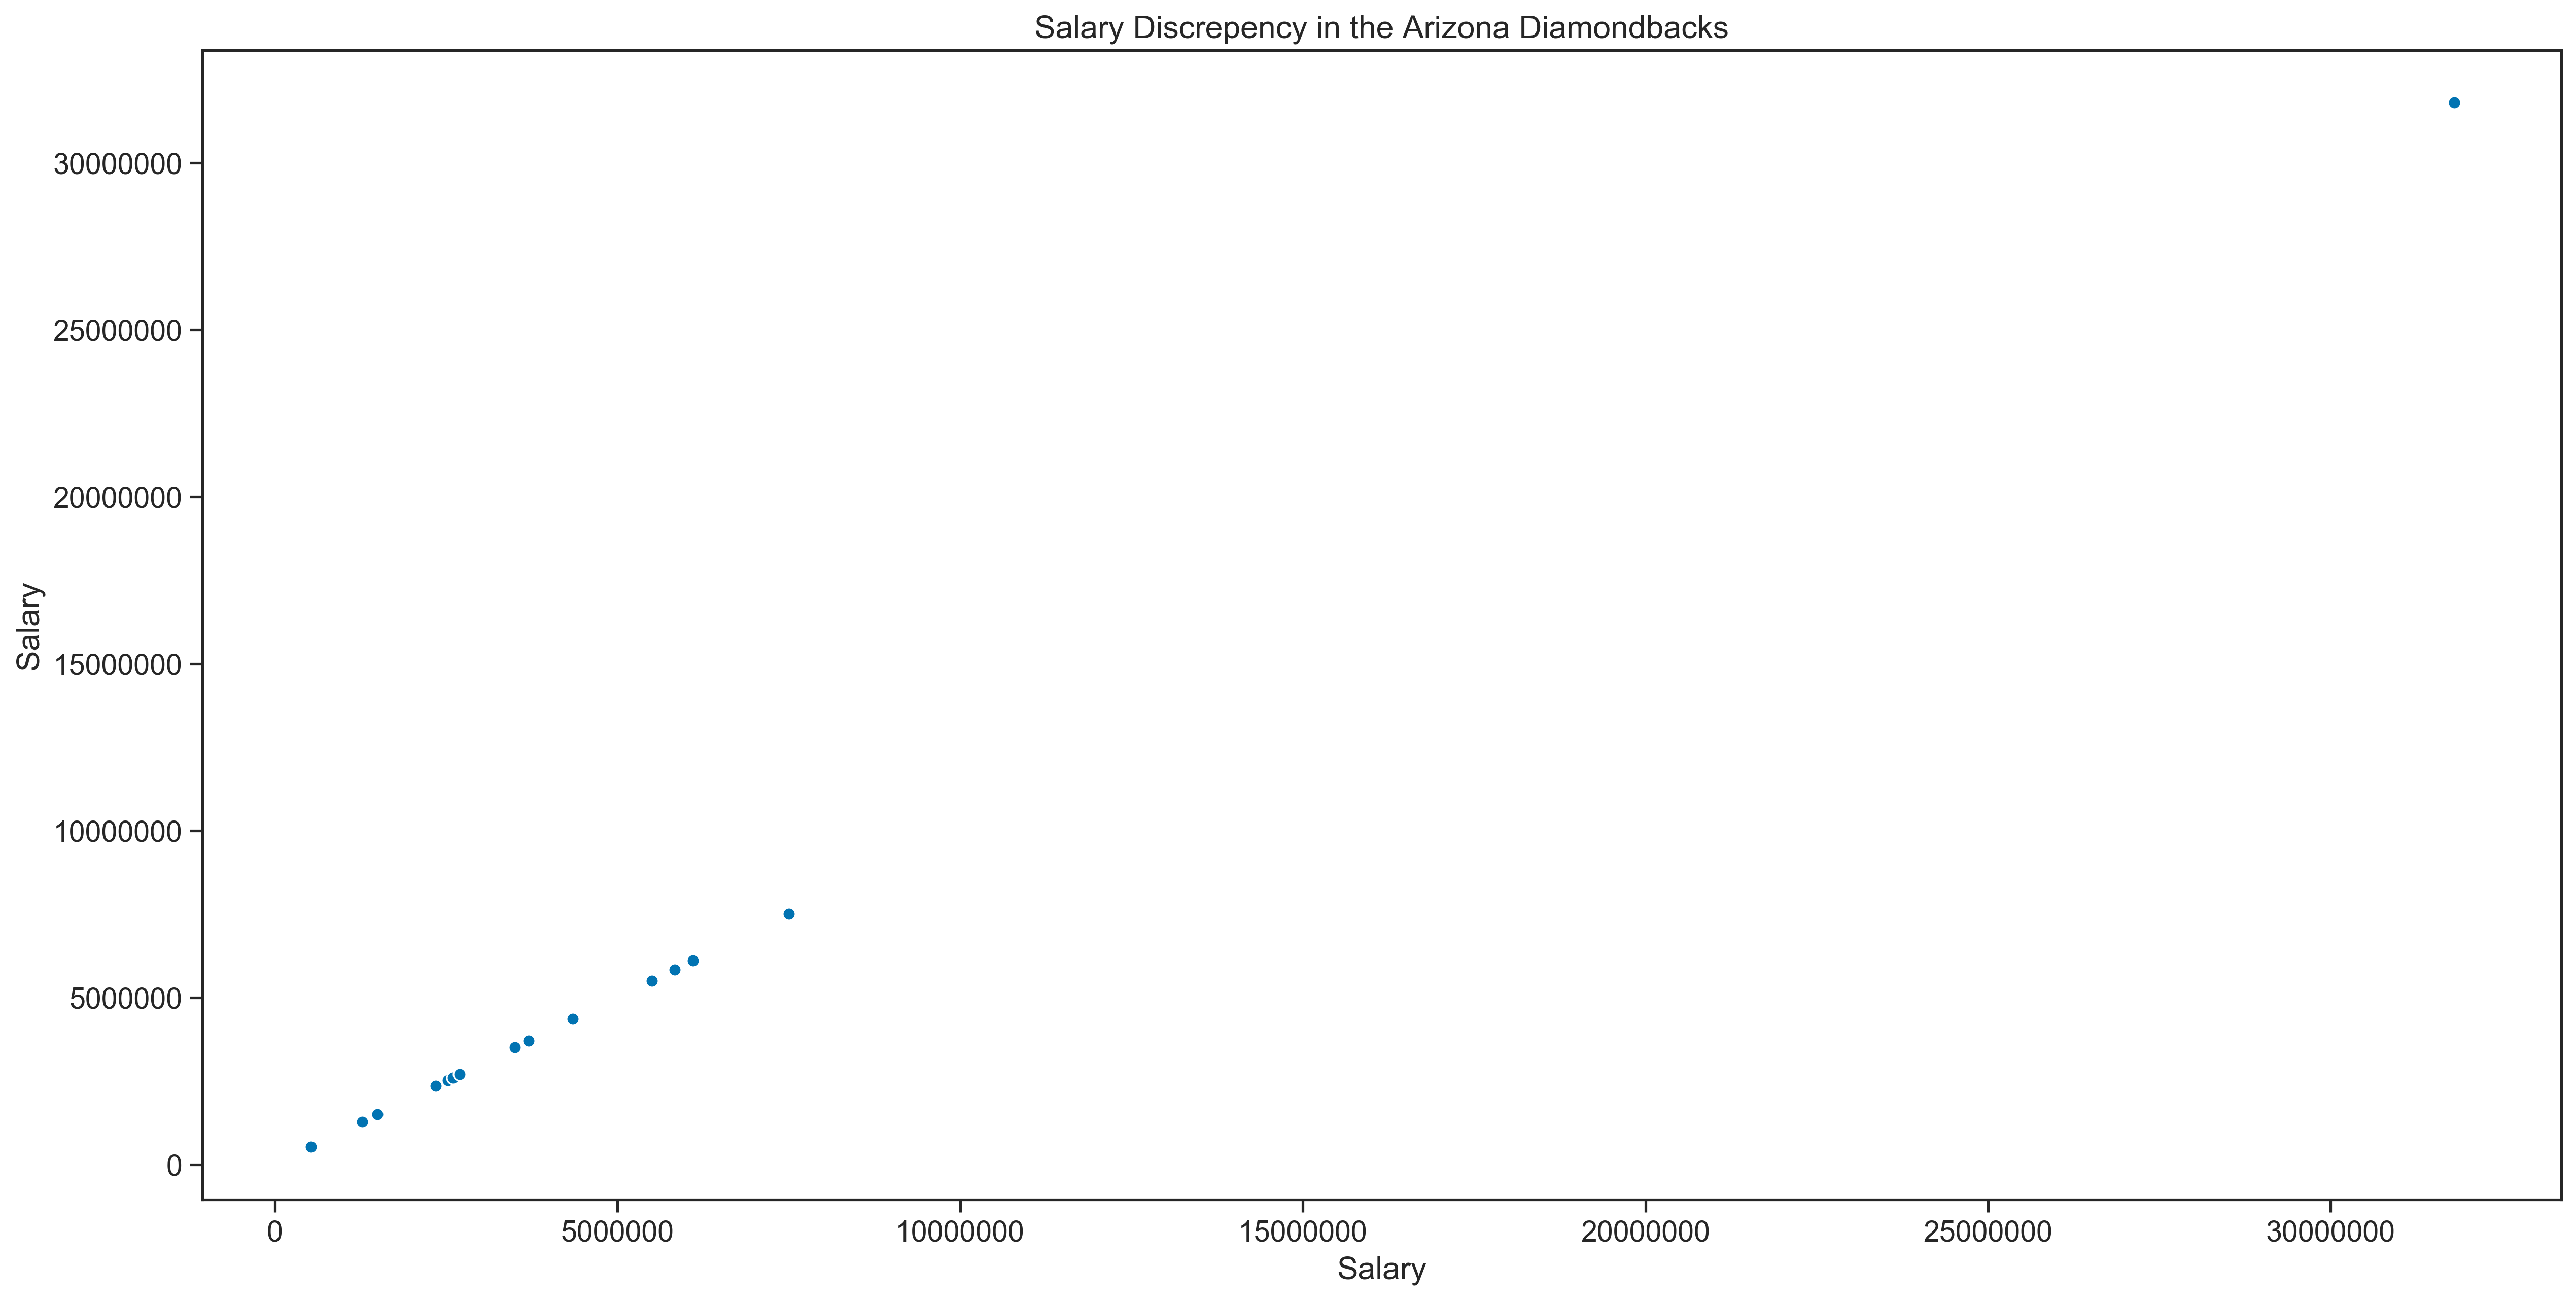

In [8]:
yearID = largest_variance["yearID"]
teamID = largest_variance["teamID"]
lgID = largest_variance["lgID"]
team_name = largest_variance["team_name"]

sns.scatterplot(team_salaries[(yearID, teamID, lgID)],team_salaries[(yearID, teamID, lgID)])

ax = plt.gca()
ax.get_xaxis().get_major_formatter().set_scientific(False)
ax.get_yaxis().get_major_formatter().set_scientific(False)

plt.ylabel("Salary")
plt.xlabel("Salary")
plt.title(f"Salary Discrepency in the {team_name}")

plt.savefig("./figures/salary_discrepency.png")

In [9]:
data[data["salary"] == team_salaries[(yearID, teamID, lgID)].max()]

yearID teamID lgID   playerID    salary  Rank nameFirst nameLast  \
20253    2016    ARI   NL  greinza01  31799030     4      Zack  Greinke   

                       name  attendance   W   L  
20253  Arizona Diamondbacks   2036216.0  69  93

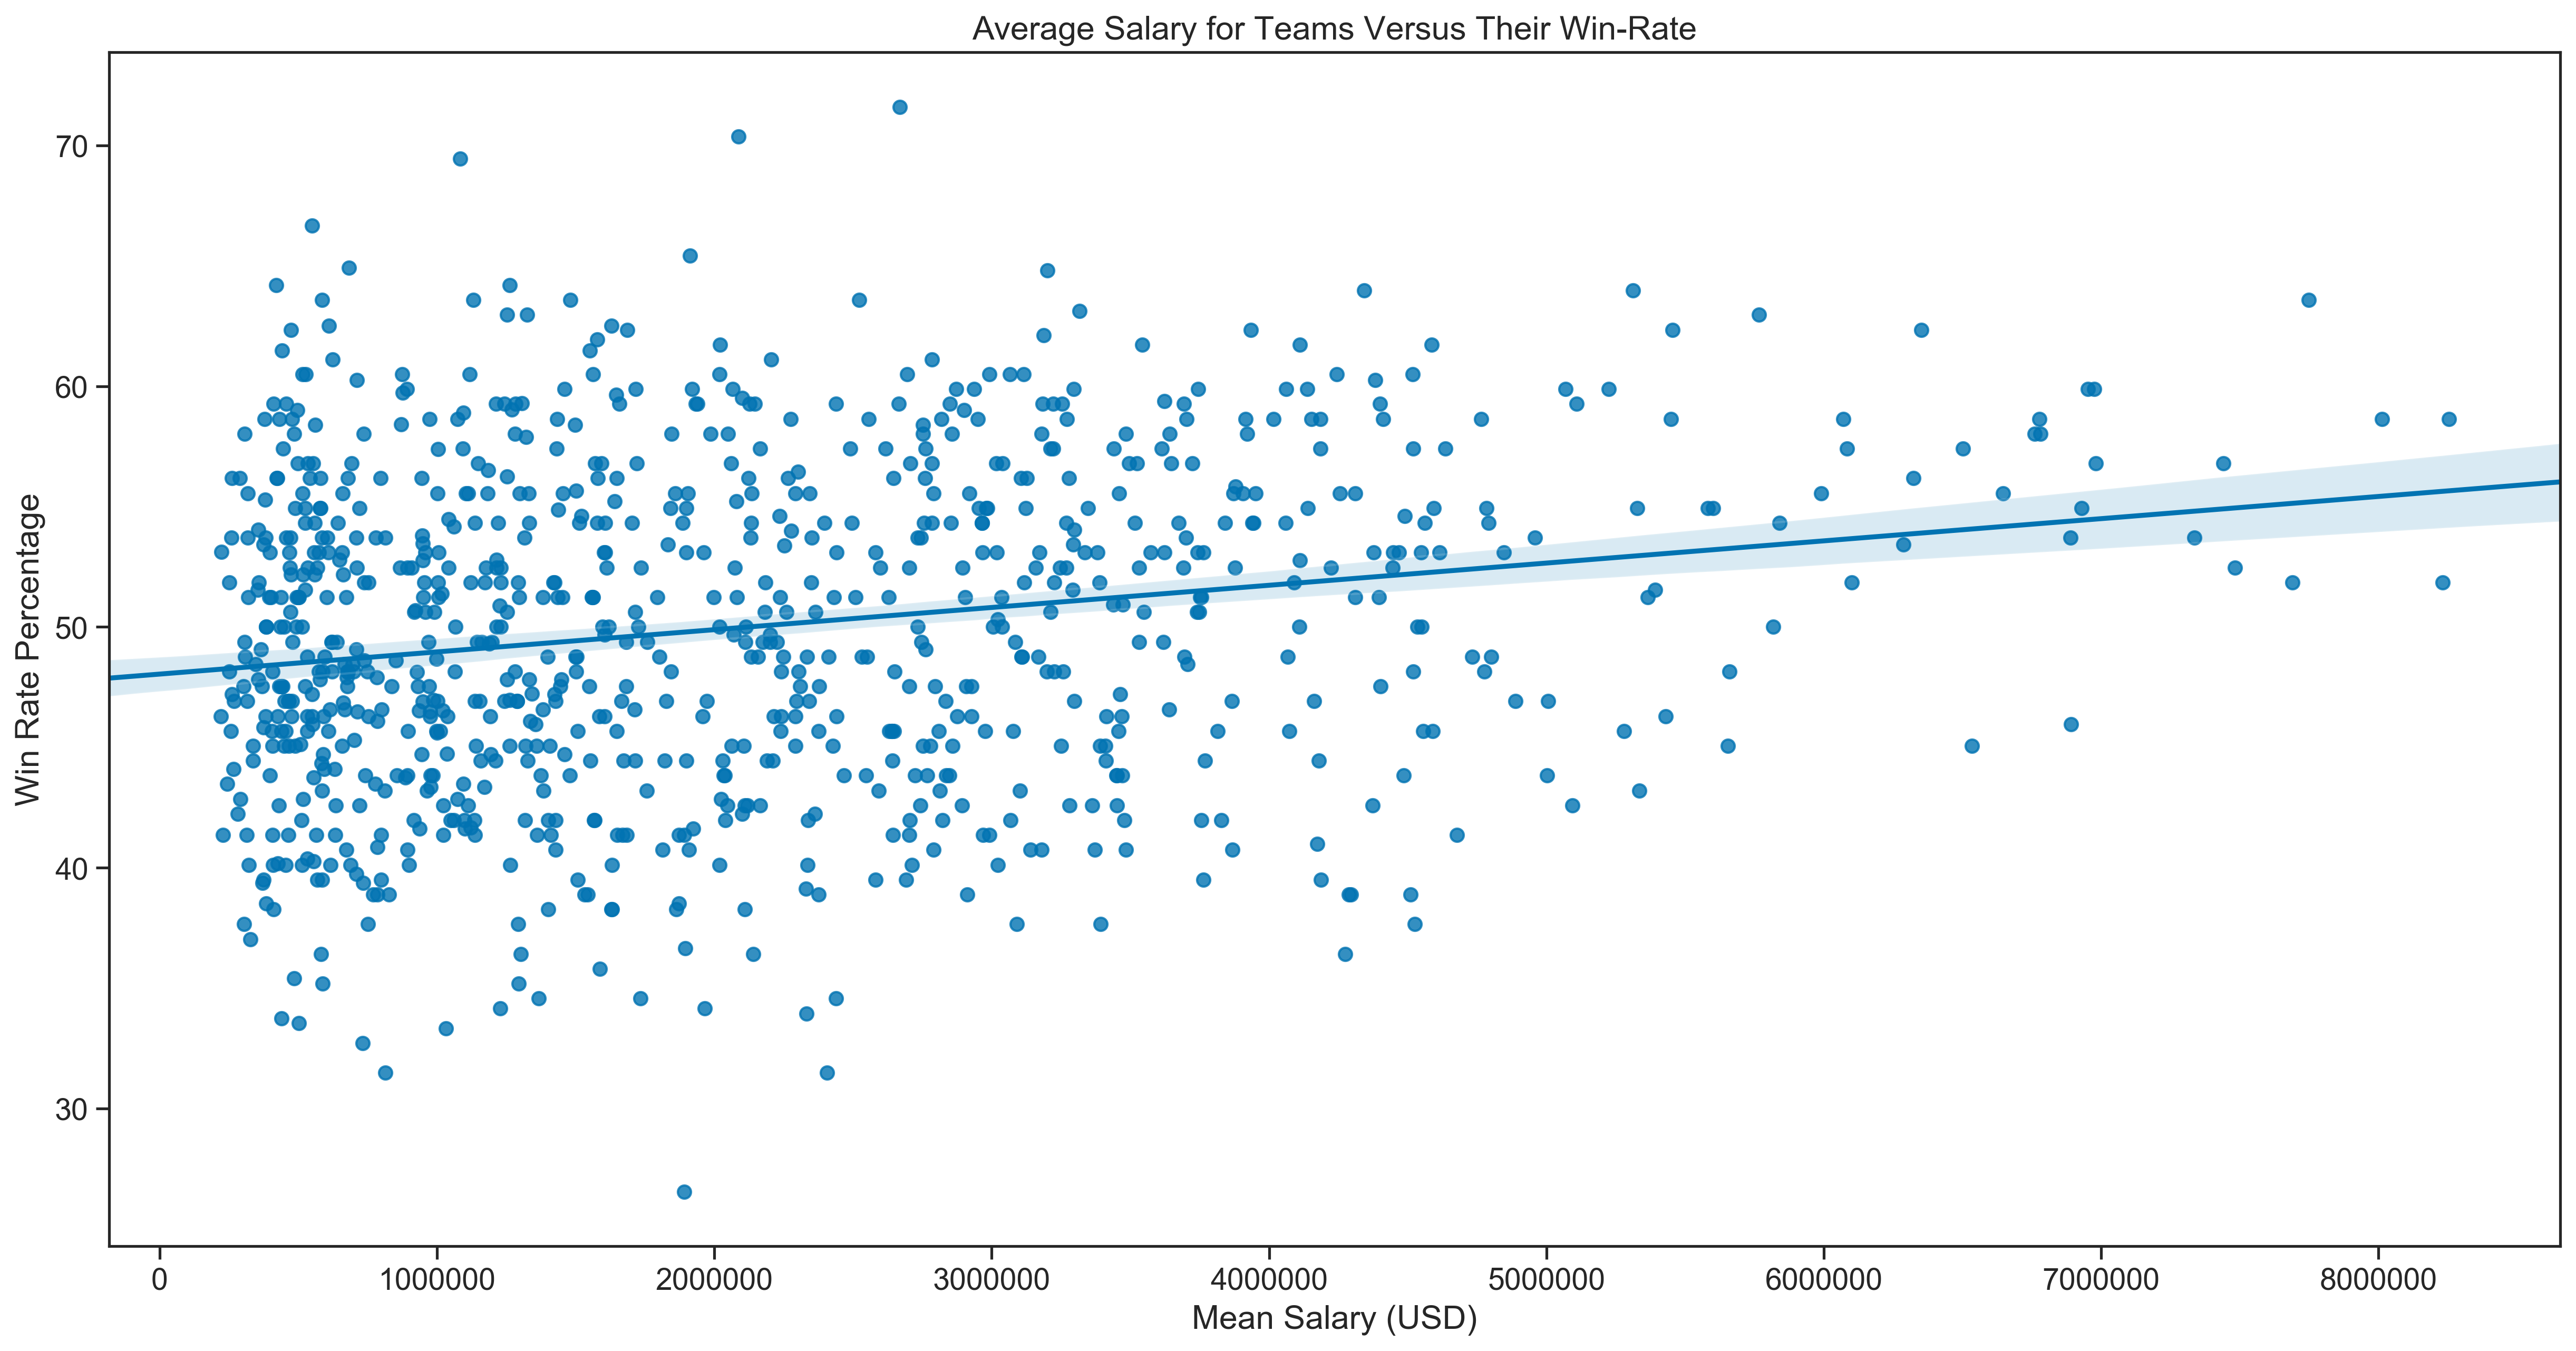

In [10]:
sns.regplot(x="mean",y="win_percentage",data=data_analysis)
plt.title("Average Salary for Teams Versus Their Win-Rate")
plt.xlabel("Mean Salary (USD)")
plt.ylabel("Win Rate Percentage")
plt.savefig("./figures/meansalary_vs_winrate.png")

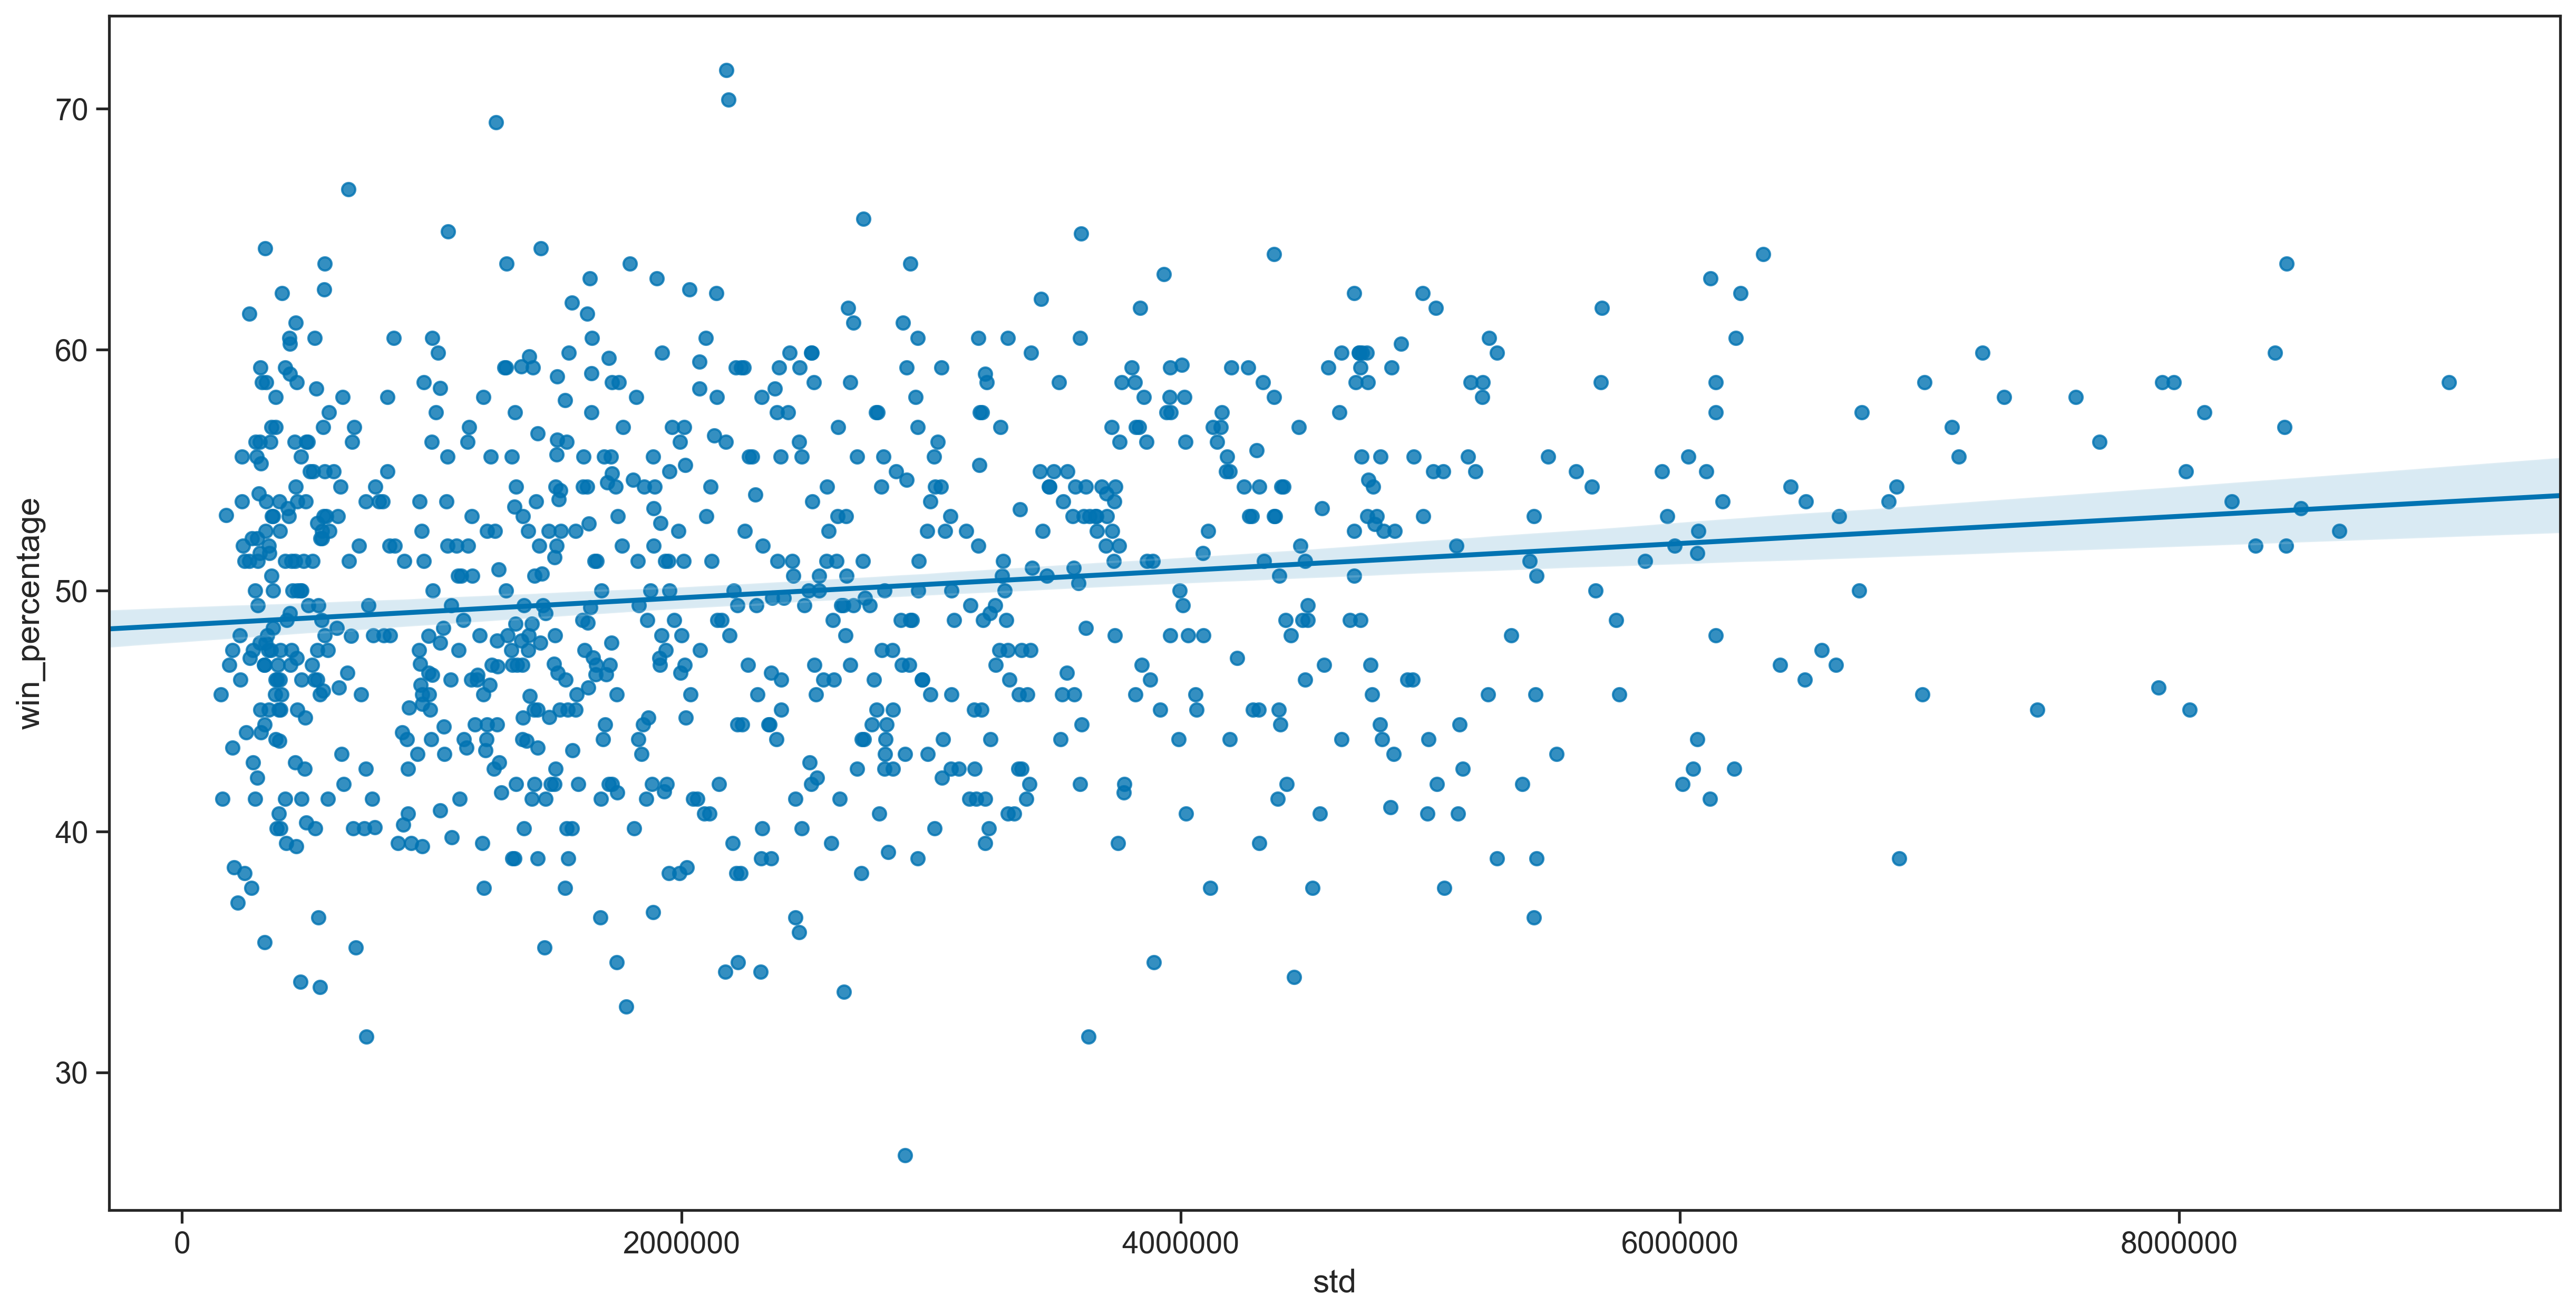

In [11]:
sns.regplot(x="std",y="win_percentage",data=data_analysis)

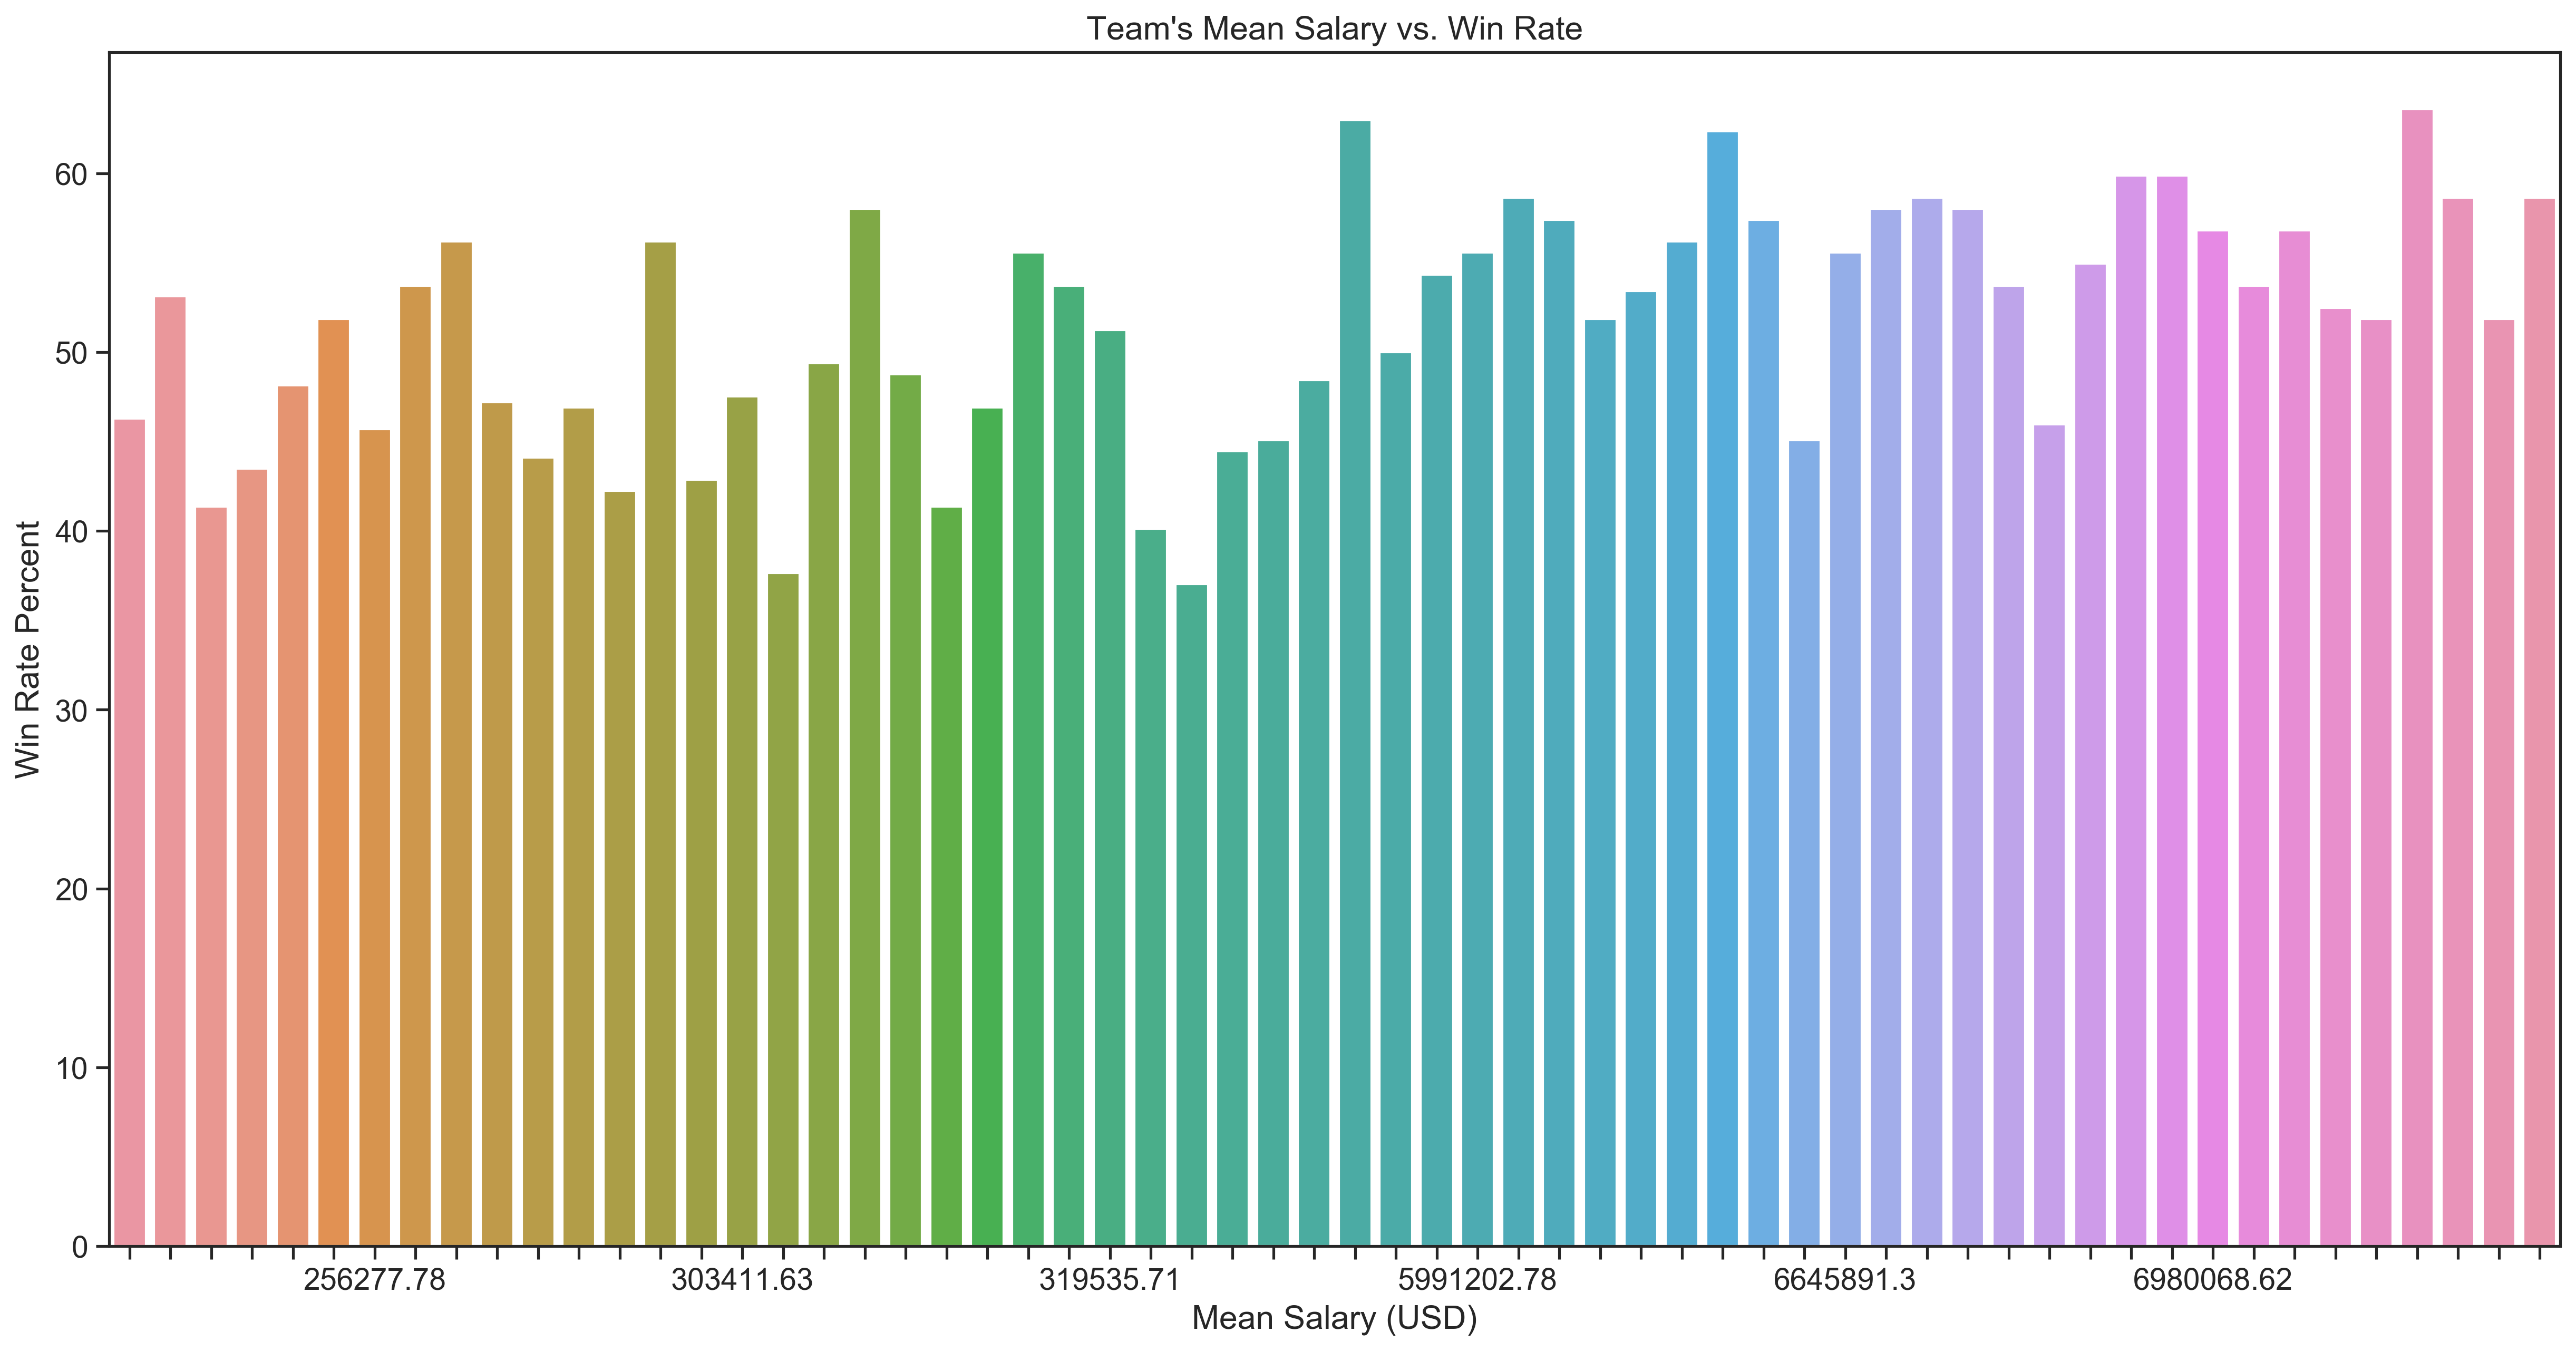

In [12]:
# Get top 30 and bottom 30 teams based on their mean salary
data_analysis = data_analysis.sort_values(by=["mean"])
temp_df = data_analysis.head(30)
temp_df = temp_df.append(data_analysis.tail(30))

# Plot
plot_ = sns.barplot(x="mean",y="win_percentage",data=temp_df)
plt.title("Team's Mean Salary vs. Win Rate")
plt.xlabel("Mean Salary (USD)")
plt.ylabel("Win Rate Percent")

# Decrease tick quantity
x = 2
for label in plot_.get_xticklabels():
    x += 1
    if x % 9 == 0:  
        label.set_visible(True)
    else:
        label.set_visible(False)
        
plt.savefig("./figures/meansalary_vs_winrate.png")